In [2]:
import numpy as np
import newt.glib as glb
import newt.glibShapes as gshp
import newt.pg2Multi as p2m
import matplotlib.pyplot as plt

#constants used

DENSITY = 2700 #aluminum density
N = 400
INNER_RAD = .0475
OUTER_RAD = .05 #5cm is roughly 2in
THICK = OUTER_RAD-INNER_RAD
HEIGHT = .152 #roughly 6in
BEAM_THICK = np.pi/10 #really beam half angle
M_FACTOR = 1 #ignore for now
MASS_SHIFTED_CIRCLE = (DENSITY*THICK*np.pi*(OUTER_RAD-INNER_RAD)**2)
MASS_BEAM = (DENSITY*BEAM_THICK/2*HEIGHT*(OUTER_RAD-INNER_RAD)**2)
#MASS_LEFTOVER = int((1-M_FACTOR)*TOTAL_MASS) #ignore for now

In [3]:
#both rotates and translates a mass object, can use either-or or both

def rotate_trans(mass_object, rotation, translation):
    return glb.translate_point_array(glb.rotate_point_array(mass_object, rotation, [0, 0, 1]), translation)

(-0.17, 0.17)

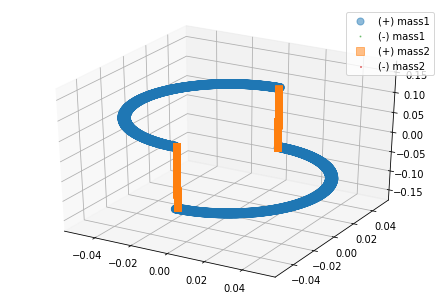

In [4]:
#trying to create shape from autocad

#wedge(mass, r1, r2, thickness, half angle, nxy, nz)
#combines two semicircles into one mass object, semicircles at +- OUTER_RAD/2
wedge = gshp.wedge(MASS_SHIFTED_CIRCLE, INNER_RAD, OUTER_RAD, THICK, np.pi/2, N, 1)
wedge1shifted = glb.translate_point_array(wedge, [0, 0, -HEIGHT/2])
wedge2shifted = rotate_trans(wedge, np.pi, [0, 0, HEIGHT/2])
wedgescombined = np.concatenate([wedge1shifted, wedge2shifted])

#combines two edges connecting semicircles into one mass object
beam = gshp.wedge(MASS_BEAM, INNER_RAD, OUTER_RAD, HEIGHT, BEAM_THICK, 1, N)
beam1shifted = rotate_trans(beam, np.pi/2, [0, 0, 0])
beam2shifted = rotate_trans(beam, 3*np.pi/2, [0, 0, 0])
beamscombined = np.concatenate([beam1shifted, beam2shifted])

fig, ax = glb.display_points(wedgescombined, beamscombined)
ax.set_zlim([-.17, .17])

In [5]:
#calculating moments

totalmass = np.concatenate([wedgescombined, beamscombined])
print(p2m.qmoment(2, 1, totalmass))

#print(p2m.Qmomentb(2, 1, totalmass))
#print(p2m.qmoments(2, totalmass))

(4.835623818980229e-07+1.5881867761018131e-22j)


In [6]:
#varying parameters to find optimal moment

ran = 100

def make_small(l, mag = 1):
    return [l/(i+mag) for i in range(ran)]
def make_large(l, mag = 1):
    return [l*(i+mag) for i in range(ran)]
def incl(l, mag = 1):
    return [l*(1+mag*(i-ran/2)) for i in range(ran)]

#can probably ignore these, variation is quite large

HEIGHTSMALL = make_small(HEIGHT)#lowers Q21
HEIGHTLARGE = make_large(HEIGHT)#raises Q21
INNERRADSMALL = make_small(INNER_RAD)
INNERRADLARGE = make_large(INNER_RAD)
OUTERRADSMALL = make_small(OUTER_RAD)
OUTERRADLARGE = make_large(OUTER_RAD)
CIRCLESMALL = [DENSITY*(OUTERRADSMALL[i]-INNERRADSMALL[i])*np.pi*(OUTERRADSMALL[i]-OUTERRADSMALL[i])**2 for i in range(len(OUTERRADSMALL))]
BEAMSMALL = [DENSITY*BEAM_THICK/2*HEIGHTSMALL[i]*(OUTERRADSMALL[i]-INNERRADSMALL[i])**2 for i in range(len(OUTERRADSMALL))]
CIRCLELARGE = [DENSITY*(OUTERRADLARGE[i]-INNERRADLARGE[i])*np.pi*(OUTERRADLARGE[i]-INNERRADLARGE[i])**2 for i in range(len(OUTERRADSMALL))]
BEAMLARGE = [DENSITY*BEAM_THICK/2*HEIGHTLARGE[i]*(OUTERRADLARGE[i]-INNERRADLARGE[i])**2 for i in range(len(OUTERRADSMALL))]

#small variations (inc = increment)

HEIGHTINC = incl(HEIGHT, .01)
BEAMINC = [(DENSITY*BEAM_THICK/2*i*(OUTER_RAD-INNER_RAD)**2)/2 for i in HEIGHTINC]
OUTERRADINC = incl(OUTER_RAD, .001)
INNERRADINC = incl(INNER_RAD, .001)
THICKINC = [OUTERRADINC[i] - INNERRADINC[i] for i in range(len(OUTERRADINC))]
CIRCLEINC = [(DENSITY*THICKINC[i]*np.pi*(OUTERRADINC[i]-INNERRADINC[i])**2)/2 for i in range(len(OUTERRADINC))]

In [ ]:
#mostly ineffective for actually computing moments as the heights either increase or decrease greatly

#decreasing height on a large scale
for i in HEIGHTSMALL:
    #wedge(mass, r1, r2, thickness, half angle, nxy, nz)
    #combines two semicircles into one mass object, semicircles at +- OUTER_RAD/2
    wedge = gshp.wedge(MASS_SHIFTED_CIRCLE, INNER_RAD, OUTER_RAD, THICK, np.pi/2, N, 1)
    wedge1shifted = glb.translate_point_array(wedge, [0, 0, -i/2])
    wedge2shifted = rotate_trans(wedge, np.pi, [0, 0, i/2])
    wedgescombined = np.concatenate([wedge1shifted, wedge2shifted])

    #combines two edges connecting semicircles into one mass object
    beam = gshp.wedge(MASS_BEAM, INNER_RAD, OUTER_RAD, i, BEAM_THICK, 1, N)
    beam1shifted = rotate_trans(beam, np.pi/2, [0, 0, 0])
    beam2shifted = rotate_trans(beam, 3*np.pi/2, [0, 0, 0])
    beamscombined = np.concatenate([beam1shifted, beam2shifted])

    fig, ax = glb.display_points(wedgescombined, beamscombined)
    ax.set_zlim([-.05, .05])

    #calculating moments
    totalmass = np.concatenate([wedgescombined, beamscombined])
    print(p2m.qmoment(2, 1, totalmass), i)

In [7]:
#looking at height inc

moments = []
for i in range(len(HEIGHTINC)):
    #wedge(mass, r1, r2, thickness, half angle, nxy, nz)
    #combines two semicircles into one mass object, semicircles at +- OUTER_RAD/2
    wedge = gshp.wedge(MASS_SHIFTED_CIRCLE, INNER_RAD, OUTER_RAD, HEIGHTINC[i], np.pi/2, N, 1)
    wedge1shifted = glb.translate_point_array(wedge, [0, 0, -HEIGHTINC[i]/2])
    wedge2shifted = rotate_trans(wedge, np.pi, [0, 0, HEIGHTINC[i]/2])
    wedgescombined = np.concatenate([wedge1shifted, wedge2shifted])

    #combines two edges connecting semicircles into one mass object
    beam = gshp.wedge(BEAMINC[i], INNER_RAD, OUTER_RAD, HEIGHTINC[i], BEAM_THICK, 1, N)
    beam1shifted = rotate_trans(beam, np.pi/2, [0, 0, 0])
    beam2shifted = rotate_trans(beam, 3*np.pi/2, [0, 0, 0])
    beamscombined = np.concatenate([beam1shifted, beam2shifted])

    #fig, ax = glb.display_points(wedgescombined, beamscombined)
    #ax.set_zlim([-.17, .17])

    #calculating moments
    totalmass = np.concatenate([wedgescombined, beamscombined])
    print(p2m.qmoment(2, 1, totalmass))
    moments.append(p2m.qmoment(2, 1, totalmass))

(2.417811909490114e-07+6.617444900424221e-23j)
(2.4661681476799165e-07+3.639594695233322e-23j)
(2.5145243858697186e-07+2.6469779601696886e-23j)
(2.562880624059521e-07+3.639594695233322e-23j)
(2.611236862249322e-07+4.632211430296955e-23j)
(2.659593100439126e-07+5.293955920339377e-23j)
(2.707949338628928e-07+5.293955920339377e-23j)
(2.7563055768187306e-07+5.955700410381799e-23j)
(2.8046618150085327e-07+2.6469779601696886e-23j)
(2.853018053198334e-07+5.955700410381799e-23j)
(2.901374291388137e-07+6.617444900424221e-23j)
(2.9497305295779395e-07+5.955700410381799e-23j)
(2.9980867677677416e-07+5.955700410381799e-23j)
(3.0464430059575436e-07+3.3087224502121107e-23j)
(3.094799244147346e-07+7.940933880509066e-23j)
(3.143155482337148e-07+3.3087224502121107e-23j)
(3.1915117205269494e-07+3.3087224502121107e-23j)
(3.239867958716753e-07+6.617444900424221e-23j)
(3.2882241969065546e-07+6.617444900424221e-23j)
(3.336580435096357e-07+5.955700410381799e-23j)
(3.38493667328616e-07+7.279189390466644e-23j)


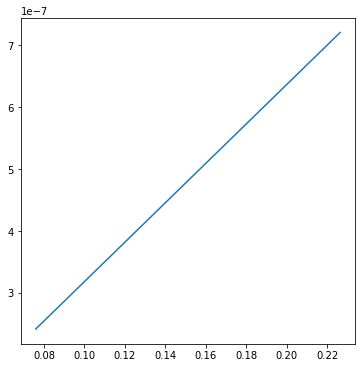

In [9]:
#plotting height increments against the produced moments

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(HEIGHTINC, moments)
plt.show()

In [10]:
#looking at radius increments

moments2 = []
for i in range(len(OUTERRADINC)):
    #wedge(mass, r1, r2, thickness, half angle, nxy, nz)
    #combines two semicircles into one mass object, semicircles at +- OUTER_RAD/2
    wedge = gshp.wedge(CIRCLEINC[i], INNERRADINC[i], OUTERRADINC[i], HEIGHT, np.pi/2, N, 1)
    wedge1shifted = glb.translate_point_array(wedge, [0, 0, -HEIGHT/2])
    wedge2shifted = rotate_trans(wedge, np.pi, [0, 0, HEIGHT/2])
    wedgescombined = np.concatenate([wedge1shifted, wedge2shifted])

    #combines two edges connecting semicircles into one mass object
    beam = gshp.wedge(MASS_BEAM, INNERRADINC[i], OUTERRADINC[i], HEIGHT, BEAM_THICK, 1, N)
    beam1shifted = rotate_trans(beam, np.pi/2, [0, 0, 0])
    beam2shifted = rotate_trans(beam, 3*np.pi/2, [0, 0, 0])
    beamscombined = np.concatenate([beam1shifted, beam2shifted])

    #fig, ax = glb.display_points(wedgescombined, beamscombined)
    #ax.set_zlim([-.17, .17])

    #calculating moments
    totalmass = np.concatenate([wedgescombined, beamscombined])
    moments2.append(p2m.qmoment(2, 1, totalmass))
    print(moments2[i])

(1.9693229116041314e-07+7.940933880509066e-23j)
(1.9776278991893278e-07-2.6469779601696886e-23j)
(1.985959126837464e-07+0j)
(1.9943166497616755e-07+7.940933880509066e-23j)
(2.0027005232331622e-07+1.0587911840678754e-22j)
(2.0111108025811471e-07+7.940933880509066e-23j)
(2.0195475431928483e-07+5.293955920339377e-23j)
(2.0280108005135292e-07+2.6469779601696886e-23j)
(2.0365006300464618e-07+7.940933880509066e-23j)
(2.0450170873529997e-07-5.293955920339377e-23j)
(2.053560228052453e-07+0j)
(2.0621301078222278e-07+0j)
(2.070726782397709e-07+1.3234889800848443e-22j)
(2.079350307572304e-07+2.6469779601696886e-23j)
(2.088000739197505e-07+5.293955920339377e-23j)
(2.0966781331827766e-07+2.6469779601696886e-23j)
(2.1053825454956104e-07+2.6469779601696886e-23j)
(2.1141140321615825e-07+2.6469779601696886e-23j)
(2.122872649264217e-07+5.293955920339377e-23j)
(2.131658452945147e-07+0j)
(2.1404714994039726e-07+0j)
(2.149311844898342e-07+0j)
(2.158179545743909e-07+1.0587911840678754e-22j)
(2.1670746583143

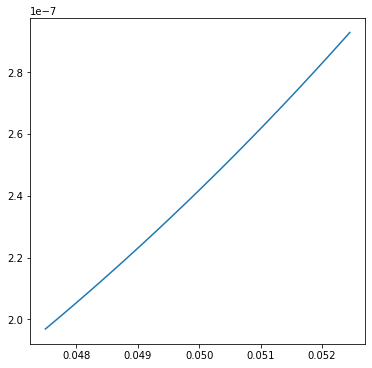

In [100]:
#looking at radius increments vs moments

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(OUTERRADINC, moments2)
plt.show()

In [15]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#TAKES A LONG TIME TO RUN, DON'T ACCIDENTALLY RUN
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

#looking at both height and radius increments
momentinc = []
for i in range(len(OUTERRADINC)):
    momentplace = []
    for j in range(len(HEIGHTINC)):
        #wedge(mass, r1, r2, thickness, half angle, nxy, nz)
        #combines two semicircles into one mass object, semicircles at +- OUTER_RAD/2
        wedge = gshp.wedge(CIRCLEINC[i], INNERRADINC[i], OUTERRADINC[i], HEIGHTINC[j], np.pi/2, N, 1)
        wedge1shifted = glb.translate_point_array(wedge, [0, 0, -HEIGHTINC[j]/2])
        wedge2shifted = rotate_trans(wedge, np.pi, [0, 0, HEIGHTINC[j]/2])
        wedgescombined = np.concatenate([wedge1shifted, wedge2shifted])

        #combines two edges connecting semicircles into one mass object
        beam = gshp.wedge(MASS_BEAM, INNERRADINC[i], OUTERRADINC[i], HEIGHTINC[j], BEAM_THICK, 1, N)
        beam1shifted = rotate_trans(beam, np.pi/2, [0, 0, 0])
        beam2shifted = rotate_trans(beam, 3*np.pi/2, [0, 0, 0])
        beamscombined = np.concatenate([beam1shifted, beam2shifted])

        #fig, ax = glb.display_points(wedgescombined, beamscombined)
        #ax.set_zlim([-.17, .17])

        #calculating moments
        totalmass = np.concatenate([wedgescombined, beamscombined])
        momentplace.append(p2m.qmoment(2, 1, totalmass))
        print(momentplace[j])
    momentinc.append(momentplace)

(9.846614558020657e-08+0j)
(1.0043546849181076e-07+0j)
(1.0240479140341487e-07+3.970466940254533e-23j)
(1.0437411431501897e-07+2.6469779601696886e-23j)
(1.0634343722662308e-07+3.970466940254533e-23j)
(1.083127601382273e-07+5.293955920339377e-23j)
(1.1028208304983135e-07+2.6469779601696886e-23j)
(1.122514059614355e-07+2.6469779601696886e-23j)
(1.1422072887303967e-07+2.6469779601696886e-23j)
(1.1619005178464379e-07+0j)
(1.1815937469624786e-07+0j)
(1.20128697607852e-07+3.970466940254533e-23j)
(1.2209802051945617e-07+1.3234889800848443e-23j)
(1.2406734343106033e-07+5.293955920339377e-23j)
(1.2603666634266446e-07+2.6469779601696886e-23j)
(1.2800598925426857e-07+2.6469779601696886e-23j)
(1.299753121658726e-07-2.6469779601696886e-23j)
(1.3194463507747684e-07+3.970466940254533e-23j)
(1.3391395798908092e-07-2.6469779601696886e-23j)
(1.358832809006851e-07+2.6469779601696886e-23j)
(1.3785260381228927e-07+7.940933880509066e-23j)
(1.3982192672389332e-07+5.293955920339377e-23j)
(1.4179124963549754e-

(2.570916268946126e-07-5.293955920339377e-23j)
(2.590692547938019e-07+5.293955920339377e-23j)
(2.6104688269299126e-07+5.293955920339377e-23j)
(2.6302451059218046e-07+5.293955920339377e-23j)
(2.650021384913698e-07+5.293955920339377e-23j)
(2.669797663905592e-07+7.940933880509066e-23j)
(2.6895739428974855e-07+5.293955920339377e-23j)
(2.7093502218893796e-07+1.3234889800848443e-22j)
(2.7291265008812716e-07-1.0587911840678754e-22j)
(2.7489027798731663e-07+5.293955920339377e-23j)
(2.768679058865059e-07+5.293955920339377e-23j)
(2.788455337856952e-07+2.6469779601696886e-23j)
(2.8082316168488456e-07-1.0587911840678754e-22j)
(2.828007895840738e-07+2.6469779601696886e-23j)
(2.847784174832632e-07+2.117582368135751e-22j)
(2.8675604538245243e-07+1.0587911840678754e-22j)
(2.8873367328164184e-07+5.293955920339377e-23j)
(2.9071130118083115e-07+2.6469779601696886e-23j)
(2.9268892908002057e-07+1.5881867761018131e-22j)
(2.946665569792098e-07+5.293955920339377e-23j)
(9.92979563418732e-08+2.6469779601696886e

(2.1738051482402268e-07+2.6469779601696886e-23j)
(2.1937483147378435e-07+0j)
(2.21369148123546e-07-5.293955920339377e-23j)
(2.233634647733077e-07+2.6469779601696886e-23j)
(2.253577814230693e-07+5.293955920339377e-23j)
(2.2735209807283106e-07+0j)
(2.293464147225927e-07+2.6469779601696886e-23j)
(2.3134073137235434e-07+0j)
(2.3333504802211598e-07+2.6469779601696886e-23j)
(2.353293646718777e-07+5.293955920339377e-23j)
(2.3732368132163942e-07+7.940933880509066e-23j)
(2.393179979714011e-07+5.293955920339377e-23j)
(2.413123146211628e-07+5.293955920339377e-23j)
(2.433066312709244e-07+7.940933880509066e-23j)
(2.45300947920686e-07+7.940933880509066e-23j)
(2.472952645704477e-07+7.940933880509066e-23j)
(2.4928958122020945e-07+2.6469779601696886e-23j)
(2.5128389786997114e-07+5.293955920339377e-23j)
(2.5327821451973273e-07-5.293955920339377e-23j)
(2.5527253116949453e-07+1.0587911840678754e-22j)
(2.5726684781925606e-07-2.6469779601696886e-23j)
(2.592611644690178e-07+7.940933880509066e-23j)
(2.6125548

(1.8703330464004668e-07+1.3234889800848443e-22j)
(1.8904441544262782e-07+1.3234889800848443e-23j)
(1.9105552624520896e-07+1.3234889800848443e-23j)
(1.930666370477901e-07+3.970466940254533e-23j)
(1.9507774785037121e-07+5.293955920339377e-23j)
(1.9708885865295238e-07+5.293955920339377e-23j)
(1.9909996945553357e-07+2.6469779601696886e-23j)
(2.0111108025811471e-07+7.940933880509066e-23j)
(2.0312219106069583e-07+5.293955920339377e-23j)
(2.0513330186327702e-07+0j)
(2.0714441266585816e-07+1.0587911840678754e-22j)
(2.0915552346843928e-07+0j)
(2.1116663427102047e-07-5.293955920339377e-23j)
(2.131777450736016e-07+2.6469779601696886e-23j)
(2.1518885587618275e-07+7.940933880509066e-23j)
(2.171999666787639e-07-5.293955920339377e-23j)
(2.1921107748134509e-07+0j)
(2.2122218828392623e-07+2.6469779601696886e-23j)
(2.2323329908650737e-07+7.940933880509066e-23j)
(2.252444098890885e-07-5.293955920339377e-23j)
(2.2725552069166957e-07+7.940933880509066e-23j)
(2.292666314942508e-07+1.0587911840678754e-22j)
(

(1.561568316395418e-07+2.6469779601696886e-23j)
(1.5818484244005531e-07+3.970466940254533e-23j)
(1.6021285324056887e-07+5.293955920339377e-23j)
(1.6224086404108238e-07+5.293955920339377e-23j)
(1.642688748415959e-07+0j)
(1.6629688564210942e-07+5.293955920339377e-23j)
(1.6832489644262296e-07-3.970466940254533e-23j)
(1.7035290724313646e-07-2.6469779601696886e-23j)
(1.7238091804364997e-07+9.26442286059391e-23j)
(1.7440892884416356e-07+1.0587911840678754e-22j)
(1.7643693964467706e-07+2.6469779601696886e-23j)
(1.7846495044519057e-07+5.293955920339377e-23j)
(1.8049296124570413e-07+5.293955920339377e-23j)
(1.8252097204621767e-07+2.6469779601696886e-23j)
(1.8454898284673117e-07+1.3234889800848443e-22j)
(1.865769936472447e-07+2.6469779601696886e-23j)
(1.8860500444775824e-07+5.293955920339377e-23j)
(1.9063301524827177e-07+6.617444900424221e-23j)
(1.926610260487853e-07+1.3234889800848443e-23j)
(1.9468903684929884e-07-2.6469779601696886e-23j)
(1.9671704764981232e-07-2.6469779601696886e-23j)
(1.9874

(1.1656597397912099e-07+0j)
(1.1861099106647399e-07+0j)
(1.2065600815382695e-07+0j)
(1.2270102524117995e-07+0j)
(1.2474604232853297e-07+1.3234889800848443e-23j)
(1.2679105941588594e-07+3.970466940254533e-23j)
(1.2883607650323896e-07+0j)
(1.30881093590592e-07+3.970466940254533e-23j)
(1.3292611067794496e-07+1.3234889800848443e-23j)
(1.3497112776529793e-07+0j)
(1.3701614485265095e-07+2.6469779601696886e-23j)
(1.39061161940004e-07-1.3234889800848443e-23j)
(1.4110617902735697e-07-1.3234889800848443e-23j)
(1.4315119611470997e-07+3.970466940254533e-23j)
(1.4519621320206297e-07+0j)
(1.4724123028941597e-07+2.6469779601696886e-23j)
(1.49286247376769e-07+2.6469779601696886e-23j)
(1.51331264464122e-07+7.940933880509066e-23j)
(1.5337628155147498e-07+1.3234889800848443e-23j)
(1.5542129863882798e-07+2.6469779601696886e-23j)
(1.5746631572618103e-07+6.617444900424221e-23j)
(1.5951133281353398e-07+0j)
(1.6155634990088708e-07-2.6469779601696886e-23j)
(1.6360136698823997e-07+5.293955920339377e-23j)
(1.656

(2.936591126115007e-07+5.293955920339377e-23j)
(2.957126728395531e-07+2.117582368135751e-22j)
(2.9776623306760566e-07+7.940933880509066e-23j)
(2.9981979329565816e-07+7.940933880509066e-23j)
(3.018733535237105e-07+5.293955920339377e-23j)
(3.0392691375176304e-07+1.5881867761018131e-22j)
(3.059804739798154e-07-5.293955920339377e-23j)
(1.0310650539111139e-07-1.3234889800848443e-23j)
(1.0516863549893363e-07+2.6469779601696886e-23j)
(1.0723076560675585e-07+0j)
(1.092928957145781e-07+0j)
(1.1135502582240032e-07+0j)
(1.1341715593022254e-07+2.6469779601696886e-23j)
(1.1547928603804475e-07-1.3234889800848443e-23j)
(1.1754141614586701e-07+2.6469779601696886e-23j)
(1.196035462536892e-07+3.970466940254533e-23j)
(1.2166567636151137e-07+1.3234889800848443e-23j)
(1.2372780646933364e-07+1.3234889800848443e-23j)
(1.257899365771559e-07-5.293955920339377e-23j)
(1.2785206668497807e-07+3.970466940254533e-23j)
(1.2991419679280034e-07+2.6469779601696886e-23j)
(1.3197632690062256e-07+0j)
(1.3403845700844475e-0

(2.6091157458211134e-07+5.293955920339377e-23j)
(2.6298230136450895e-07+1.852884572118782e-22j)
(2.6505302814690673e-07+1.5881867761018131e-22j)
(2.671237549293044e-07+0j)
(2.6919448171170206e-07-2.6469779601696886e-23j)
(2.712652084940998e-07+7.940933880509066e-23j)
(2.733359352764976e-07+0j)
(2.754066620588952e-07+1.5881867761018131e-22j)
(2.7747738884129294e-07+7.940933880509066e-23j)
(2.7954811562369066e-07+0j)
(2.8161884240608833e-07+0j)
(2.8368956918848616e-07-5.293955920339377e-23j)
(2.8576029597088377e-07+0j)
(2.8783102275328155e-07+5.293955920339377e-23j)
(2.8990174953567927e-07+0j)
(2.9197247631807693e-07+7.940933880509066e-23j)
(2.9404320310047465e-07+5.293955920339377e-23j)
(2.961139298828723e-07+5.293955920339377e-23j)
(2.981846566652701e-07+0j)
(3.0025538344766776e-07+5.293955920339377e-23j)
(3.023261102300655e-07+0j)
(3.0439683701246315e-07+1.0587911840678754e-22j)
(3.064675637948609e-07+7.940933880509066e-23j)
(3.0853829057725864e-07-5.293955920339377e-23j)
(1.039675153

(2.3594408352931803e-07-2.6469779601696886e-23j)
(2.380320842685156e-07+7.940933880509066e-23j)
(2.4012008500771303e-07-2.6469779601696886e-23j)
(2.422080857469105e-07+2.6469779601696886e-23j)
(2.44296086486108e-07-5.293955920339377e-23j)
(2.4638408722530554e-07+7.940933880509066e-23j)
(2.484720879645031e-07+5.293955920339377e-23j)
(2.505600887037006e-07-2.6469779601696886e-23j)
(2.526480894428981e-07+2.6469779601696886e-23j)
(2.547360901820956e-07+1.3234889800848443e-22j)
(2.56824090921293e-07+7.940933880509066e-23j)
(2.5891209166049056e-07+1.5881867761018131e-22j)
(2.610000923996881e-07-7.940933880509066e-23j)
(2.6308809313888564e-07+1.0587911840678754e-22j)
(2.6517609387808307e-07+1.0587911840678754e-22j)
(2.672640946172806e-07+2.6469779601696886e-23j)
(2.6935209535647815e-07+2.6469779601696886e-23j)
(2.714400960956756e-07-5.293955920339377e-23j)
(2.735280968348731e-07+1.3234889800848443e-22j)
(2.756160975740707e-07+5.293955920339377e-23j)
(2.777040983132681e-07+2.6469779601696886e-

(2.042221069130742e-07-2.6469779601696886e-23j)
(2.063274894585698e-07+0j)
(2.0843287200406545e-07+5.293955920339377e-23j)
(2.1053825454956104e-07+2.6469779601696886e-23j)
(2.1264363709505665e-07-2.6469779601696886e-23j)
(2.147490196405523e-07+1.0587911840678754e-22j)
(2.1685440218604795e-07+7.940933880509066e-23j)
(2.1895978473154348e-07-2.6469779601696886e-23j)
(2.2106516727703912e-07+5.293955920339377e-23j)
(2.2317054982253475e-07+2.6469779601696886e-23j)
(2.2527593236803037e-07+7.940933880509066e-23j)
(2.2738131491352592e-07+2.6469779601696886e-23j)
(2.2948669745902161e-07+7.940933880509066e-23j)
(2.3159208000451723e-07-2.6469779601696886e-23j)
(2.336974625500128e-07-5.293955920339377e-23j)
(2.3580284509550842e-07+5.293955920339377e-23j)
(2.3790822764100398e-07+1.0587911840678754e-22j)
(2.400136101864996e-07+2.6469779601696886e-23j)
(2.4211899273199523e-07-5.293955920339377e-23j)
(2.442243752774908e-07+5.293955920339377e-23j)
(2.463297578229864e-07+2.6469779601696886e-23j)
(2.48435

(1.6558406664260894e-07+6.617444900424221e-23j)
(1.6770693929187315e-07+2.6469779601696886e-23j)
(1.6982981194113736e-07-3.970466940254533e-23j)
(1.719526845904016e-07+2.6469779601696886e-23j)
(1.740755572396658e-07+5.293955920339377e-23j)
(1.7619842988893005e-07+1.0587911840678754e-22j)
(1.7832130253819426e-07+0j)
(1.8044417518745845e-07+1.0587911840678754e-22j)
(1.8256704783672268e-07-5.293955920339377e-23j)
(1.846899204859869e-07+6.617444900424221e-23j)
(1.868127931352511e-07-1.3234889800848443e-23j)
(1.8893566578451537e-07+3.970466940254533e-23j)
(1.9105853843377953e-07+0j)
(1.9318141108304374e-07+0j)
(1.9530428373230793e-07+7.940933880509066e-23j)
(1.9742715638157216e-07+1.0587911840678754e-22j)
(1.9955002903083638e-07-1.3234889800848443e-23j)
(2.016729016801006e-07-7.940933880509066e-23j)
(2.0379577432936485e-07+7.940933880509066e-23j)
(2.05918646978629e-07+2.6469779601696886e-23j)
(2.0804151962789327e-07+5.293955920339377e-23j)
(2.1016439227715749e-07+1.0587911840678754e-22j)
(2

(1.284282899642383e-07+6.617444900424221e-23j)
(1.3056876146364232e-07+0j)
(1.3270923296304628e-07+5.293955920339377e-23j)
(1.3484970446245027e-07+0j)
(1.369901759618542e-07+3.970466940254533e-23j)
(1.3913064746125816e-07+5.293955920339377e-23j)
(1.4127111896066213e-07+2.6469779601696886e-23j)
(1.4341159046006617e-07+1.3234889800848443e-23j)
(1.4555206195947013e-07-1.3234889800848443e-23j)
(1.476925334588741e-07+2.6469779601696886e-23j)
(1.4983300495827808e-07+3.970466940254533e-23j)
(1.5197347645768204e-07-1.3234889800848443e-23j)
(1.54113947957086e-07+2.6469779601696886e-23j)
(1.5625441945648999e-07+2.6469779601696886e-23j)
(1.5839489095589397e-07+2.6469779601696886e-23j)
(1.605353624552979e-07+1.3234889800848443e-23j)
(1.626758339547019e-07+5.293955920339377e-23j)
(1.6481630545410588e-07+5.293955920339377e-23j)
(1.6695677695350984e-07+7.940933880509066e-23j)
(1.6909724845291383e-07+5.293955920339377e-23j)
(1.7123771995231782e-07+7.940933880509066e-23j)
(1.7337819145172178e-07+1.0587

(3.073515938204628e-07+5.293955920339377e-23j)
(3.095009056653611e-07+5.293955920339377e-23j)
(3.1165021751025954e-07+2.6469779601696886e-23j)
(3.1379952935515785e-07+0j)
(3.159488412000562e-07+5.293955920339377e-23j)
(3.1809815304495457e-07+1.5881867761018131e-22j)
(3.202474648898529e-07+7.940933880509066e-23j)
(1.0790897728719545e-07+3.970466940254533e-23j)
(1.1006715683293936e-07-2.6469779601696886e-23j)
(1.1222533637868329e-07+3.970466940254533e-23j)
(1.1438351592442718e-07+0j)
(1.165416954701711e-07+3.970466940254533e-23j)
(1.1869987501591504e-07-1.3234889800848443e-23j)
(1.2085805456165889e-07+2.6469779601696886e-23j)
(1.2301623410740282e-07+0j)
(1.2517441365314673e-07+2.6469779601696886e-23j)
(1.2733259319889064e-07+3.970466940254533e-23j)
(1.2949077274463452e-07+3.970466940254533e-23j)
(1.316489522903784e-07+6.617444900424221e-23j)
(1.3380713183612232e-07+5.293955920339377e-23j)
(1.3596531138186625e-07+3.970466940254533e-23j)
(1.3812349092761016e-07+0j)
(1.4028167047335405e-07+

(2.66550182972671e-07-7.940933880509066e-23j)
(2.687172576309853e-07-2.6469779601696886e-23j)
(2.708843322892998e-07+7.940933880509066e-23j)
(2.730514069476143e-07-2.6469779601696886e-23j)
(2.752184816059287e-07+0j)
(2.7738555626424304e-07+7.940933880509066e-23j)
(2.7955263092255747e-07+1.0587911840678754e-22j)
(2.817197055808718e-07+1.0587911840678754e-22j)
(2.838867802391862e-07+1.0587911840678754e-22j)
(2.860538548975007e-07+5.293955920339377e-23j)
(2.882209295558151e-07+7.940933880509066e-23j)
(2.9038800421412946e-07+7.940933880509066e-23j)
(2.9255507887244384e-07+1.0587911840678754e-22j)
(2.947221535307582e-07+1.0587911840678754e-22j)
(2.9688922818907275e-07+1.0587911840678754e-22j)
(2.9905630284738697e-07+5.293955920339377e-23j)
(3.012233775057015e-07+1.3234889800848443e-22j)
(3.0339045216401593e-07+7.940933880509066e-23j)
(3.0555752682233025e-07+0j)
(3.077246014806446e-07+7.940933880509066e-23j)
(3.0989167613895906e-07+2.6469779601696886e-23j)
(3.1205875079727344e-07+5.293955920

(2.2941947116358812e-07+5.293955920339377e-23j)
(2.3160441850800335e-07+2.6469779601696886e-23j)
(2.3378936585241839e-07+2.6469779601696886e-23j)
(2.3597431319683343e-07-7.940933880509066e-23j)
(2.381592605412486e-07+0j)
(2.403442078856637e-07+0j)
(2.4252915523007887e-07+2.6469779601696886e-23j)
(2.44714102574494e-07+2.6469779601696886e-23j)
(2.4689904991890905e-07+0j)
(2.490839972633242e-07+0j)
(2.512689446077393e-07+7.940933880509066e-23j)
(2.534538919521544e-07+7.940933880509066e-23j)
(2.5563883929656953e-07+1.0587911840678754e-22j)
(2.5782378664098465e-07+7.940933880509066e-23j)
(2.600087339853999e-07+1.0587911840678754e-22j)
(2.62193681329815e-07+1.3234889800848443e-22j)
(2.643786286742301e-07+7.940933880509066e-23j)
(2.665635760186453e-07+1.0587911840678754e-22j)
(2.6874852336306025e-07+2.6469779601696886e-23j)
(2.7093347070747537e-07+5.293955920339377e-23j)
(2.731184180518906e-07+5.293955920339377e-23j)
(2.7530336539630577e-07+2.6469779601696886e-23j)
(2.7748831274072083e-07+2.6

(1.8945201056015586e-07+1.3234889800848443e-23j)
(1.916549409155065e-07+5.293955920339377e-23j)
(1.9385787127085712e-07+3.970466940254533e-23j)
(1.960608016262078e-07+2.6469779601696886e-23j)
(1.9826373198155844e-07+7.940933880509066e-23j)
(2.0046666233690908e-07+6.617444900424221e-23j)
(2.026695926922597e-07+5.293955920339377e-23j)
(2.0487252304761043e-07+0j)
(2.0707545340296102e-07-3.970466940254533e-23j)
(2.0927838375831171e-07+2.6469779601696886e-23j)
(2.1148131411366236e-07+7.940933880509066e-23j)
(2.1368424446901295e-07+1.0587911840678754e-22j)
(2.1588717482436357e-07+0j)
(2.180901051797143e-07+5.293955920339377e-23j)
(2.2029303553506494e-07+2.6469779601696886e-23j)
(2.2249596589041555e-07+2.6469779601696886e-23j)
(2.2469889624576628e-07+1.0587911840678754e-22j)
(2.2690182660111698e-07+2.6469779601696886e-23j)
(2.2910475695646754e-07+0j)
(2.3130768731181816e-07+2.6469779601696886e-23j)
(2.3351061766716886e-07+7.940933880509066e-23j)
(2.357135480225195e-07+0j)
(2.3791647837787012e

(1.576927142381679e-07+0j)
(1.599137383823675e-07+2.6469779601696886e-23j)
(1.62134762526567e-07+0j)
(1.6435578667076657e-07+3.970466940254533e-23j)
(1.6657681081496608e-07+0j)
(1.687978349591657e-07+7.940933880509066e-23j)
(1.710188591033652e-07-2.6469779601696886e-23j)
(1.7323988324756476e-07+2.6469779601696886e-23j)
(1.7546090739176432e-07+3.970466940254533e-23j)
(1.7768193153596386e-07+5.293955920339377e-23j)
(1.7990295568016345e-07+2.6469779601696886e-23j)
(1.8212397982436293e-07+0j)
(1.8434500396856247e-07+2.6469779601696886e-23j)
(1.8656602811276206e-07-2.6469779601696886e-23j)
(1.887870522569616e-07+2.6469779601696886e-23j)
(1.910080764011611e-07+2.6469779601696886e-23j)
(1.932291005453607e-07+5.293955920339377e-23j)
(1.954501246895602e-07+1.4558378780933287e-22j)
(1.9767114883375984e-07+7.940933880509066e-23j)
(1.9989217297795935e-07+5.293955920339377e-23j)
(2.0211319712215883e-07+6.617444900424221e-23j)
(2.0433422126635845e-07+0j)
(2.0655524541055798e-07+1.0587911840678754e-2

(1.1867914574335391e-07+0j)
(1.209183749083228e-07+3.970466940254533e-23j)
(1.231576040732918e-07+2.6469779601696886e-23j)
(1.2539683323826073e-07-1.3234889800848443e-23j)
(1.2763606240322962e-07+0j)
(1.2987529156819856e-07+9.26442286059391e-23j)
(1.3211452073316747e-07+1.3234889800848443e-23j)
(1.3435374989813649e-07+1.3234889800848443e-23j)
(1.3659297906310537e-07+2.6469779601696886e-23j)
(1.3883220822807436e-07+3.970466940254533e-23j)
(1.4107143739304333e-07+9.26442286059391e-23j)
(1.433106665580123e-07+2.6469779601696886e-23j)
(1.4554989572298113e-07+5.293955920339377e-23j)
(1.4778912488795007e-07+3.970466940254533e-23j)
(1.5002835405291908e-07+2.6469779601696886e-23j)
(1.5226758321788802e-07+1.3234889800848443e-23j)
(1.5450681238285696e-07+1.3234889800848443e-23j)
(1.5674604154782585e-07+5.293955920339377e-23j)
(1.5898527071279479e-07+9.26442286059391e-23j)
(1.6122449987776372e-07+2.6469779601696886e-23j)
(1.6346372904273277e-07+5.293955920339377e-23j)
(1.6570295820770168e-07-1.32

(2.9903367941749937e-07+1.0587911840678754e-22j)
(3.012820529469542e-07+5.293955920339377e-23j)
(3.0353042647640916e-07+1.0587911840678754e-22j)
(3.057788000058639e-07+5.293955920339377e-23j)
(3.08027173535319e-07+5.293955920339377e-23j)
(3.1027554706477366e-07-5.293955920339377e-23j)
(3.1252392059422874e-07+5.293955920339377e-23j)
(3.1477229412368355e-07+2.6469779601696886e-23j)
(3.170206676531384e-07+2.117582368135751e-22j)
(3.1926904118259335e-07-1.3234889800848443e-22j)
(3.215174147120481e-07+1.0587911840678754e-22j)
(3.237657882415031e-07+0j)
(3.260141617709579e-07+1.0587911840678754e-22j)
(3.2826253530041293e-07+5.293955920339377e-23j)
(3.3051090882986774e-07+1.3234889800848443e-22j)
(3.3275928235932266e-07+7.940933880509066e-23j)
(3.3500765588877743e-07+1.0587911840678754e-22j)
(1.1287729362971312e-07-1.3234889800848443e-23j)
(1.1513483950230739e-07+2.6469779601696886e-23j)
(1.173923853749016e-07+1.3234889800848443e-23j)
(1.1964993124749588e-07+9.26442286059391e-23j)
(1.21907477

(2.6294256516229827e-07+1.5881867761018131e-22j)
(2.6520931141369737e-07+5.293955920339377e-23j)
(2.674760576650964e-07-2.6469779601696886e-23j)
(2.697428039164956e-07+2.6469779601696886e-23j)
(2.720095501678948e-07+7.940933880509066e-23j)
(2.7427629641929386e-07+5.293955920339377e-23j)
(2.7654304267069306e-07+2.6469779601696886e-23j)
(2.7880978892209205e-07+7.940933880509066e-23j)
(2.8107653517349125e-07+5.293955920339377e-23j)
(2.8334328142489035e-07-2.6469779601696886e-23j)
(2.8561002767628955e-07+1.0587911840678754e-22j)
(2.878767739276887e-07+0j)
(2.901435201790878e-07+0j)
(2.92410266430487e-07+7.940933880509066e-23j)
(2.94677012681886e-07+0j)
(2.969437589332851e-07+1.0587911840678754e-22j)
(2.9921050518468433e-07+1.0587911840678754e-22j)
(3.014772514360833e-07+0j)
(3.037439976874826e-07+7.940933880509066e-23j)
(3.060107439388816e-07-1.0587911840678754e-22j)
(3.082774901902808e-07+5.293955920339377e-23j)
(3.1054423644167997e-07+1.0587911840678754e-22j)
(3.12810982693079e-07+5.2939

(2.285231344343372e-07-2.6469779601696886e-23j)
(2.3080836577868052e-07+2.6469779601696886e-23j)
(2.3309359712302394e-07+2.6469779601696886e-23j)
(2.3537882846736725e-07+1.0587911840678754e-22j)
(2.3766405981171067e-07+7.940933880509066e-23j)
(2.39949291156054e-07+5.293955920339377e-23j)
(2.422345225003974e-07+1.0587911840678754e-22j)
(2.445197538447408e-07+2.6469779601696886e-23j)
(2.4680498518908406e-07+1.0587911840678754e-22j)
(2.4909021653342753e-07-2.6469779601696886e-23j)
(2.513754478777709e-07+0j)
(2.5366067922211426e-07+7.940933880509066e-23j)
(2.559459105664577e-07+0j)
(2.582311419108009e-07+0j)
(2.605163732551444e-07+5.293955920339377e-23j)
(2.628016045994877e-07+7.940933880509066e-23j)
(2.6508683594383103e-07+5.293955920339377e-23j)
(2.673720672881744e-07+0j)
(2.6965729863251776e-07+5.293955920339377e-23j)
(2.7194252997686123e-07+5.293955920339377e-23j)
(2.742277613212046e-07+2.6469779601696886e-23j)
(2.7651299266554797e-07+2.6469779601696886e-23j)
(2.7879822400989133e-07+1.

(1.9121782904016945e-07+5.293955920339377e-23j)
(1.9352165830571373e-07+3.970466940254533e-23j)
(1.958254875712579e-07+5.293955920339377e-23j)
(1.981293168368022e-07+7.940933880509066e-23j)
(2.0043314610234636e-07+3.970466940254533e-23j)
(2.027369753678906e-07+0j)
(2.0504080463343474e-07+5.293955920339377e-23j)
(2.0734463389897902e-07+9.26442286059391e-23j)
(2.096484631645232e-07+9.26442286059391e-23j)
(2.119522924300674e-07+5.293955920339377e-23j)
(2.1425612169561162e-07+5.293955920339377e-23j)
(2.1655995096115582e-07+0j)
(2.1886378022669997e-07+2.6469779601696886e-23j)
(2.2116760949224417e-07+2.6469779601696886e-23j)
(2.2347143875778837e-07+7.940933880509066e-23j)
(2.2577526802333265e-07+5.293955920339377e-23j)
(2.2807909728887688e-07+2.6469779601696886e-23j)
(2.3038292655442113e-07+7.940933880509066e-23j)
(2.326867558199653e-07+5.293955920339377e-23j)
(2.3499058508550956e-07+5.293955920339377e-23j)
(2.3729441435105368e-07+0j)
(2.3959824361659793e-07+2.6469779601696886e-23j)
(2.41902

(1.4632004981076164e-07+0j)
(1.4864259028394833e-07+5.293955920339377e-23j)
(1.5096513075713496e-07+1.3234889800848443e-23j)
(1.5328767123032172e-07-2.6469779601696886e-23j)
(1.556102117035084e-07+1.3234889800848443e-23j)
(1.5793275217669509e-07+5.293955920339377e-23j)
(1.6025529264988182e-07+7.940933880509066e-23j)
(1.6257783312306856e-07+5.293955920339377e-23j)
(1.649003735962552e-07+7.940933880509066e-23j)
(1.6722291406944187e-07+0j)
(1.695454545426286e-07+5.293955920339377e-23j)
(1.7186799501581527e-07+7.940933880509066e-23j)
(1.7419053548900198e-07-2.6469779601696886e-23j)
(1.7651307596218866e-07+6.617444900424221e-23j)
(1.788356164353754e-07+2.6469779601696886e-23j)
(1.8115815690856203e-07+1.5881867761018131e-22j)
(1.8348069738174874e-07+0j)
(1.8580323785493542e-07-1.3234889800848443e-23j)
(1.8812577832812216e-07+5.293955920339377e-23j)
(1.9044831880130884e-07+1.3234889800848443e-23j)
(1.927708592744955e-07+3.970466940254533e-23j)
(1.9509339974768215e-07+7.940933880509066e-23j)
(

(3.451269280233115e-07+5.293955920339377e-23j)
(3.4745886672617154e-07+1.0587911840678754e-22j)
(1.1706827131921222e-07+0j)
(1.1940963674559648e-07-2.6469779601696886e-23j)
(1.217510021719807e-07+3.970466940254533e-23j)
(1.2409236759836496e-07+1.3234889800848443e-23j)
(1.2643373302474918e-07+3.970466940254533e-23j)
(1.2877509845113348e-07+2.6469779601696886e-23j)
(1.3111646387751767e-07-1.3234889800848443e-23j)
(1.3345782930390191e-07+5.293955920339377e-23j)
(1.3579919473028616e-07+1.3234889800848443e-23j)
(1.3814056015667038e-07+1.3234889800848443e-23j)
(1.4048192558305465e-07+6.617444900424221e-23j)
(1.428232910094389e-07+1.3234889800848443e-23j)
(1.4516465643582313e-07-2.6469779601696886e-23j)
(1.475060218622074e-07+1.3234889800848443e-23j)
(1.4984738728859165e-07+0j)
(1.5218875271497584e-07+2.6469779601696886e-23j)
(1.5453011814136008e-07+1.3234889800848443e-23j)
(1.5687148356774438e-07+1.3234889800848443e-23j)
(1.592128489941286e-07-2.6469779601696886e-23j)
(1.6155421442051284e-07

(3.009050497655037e-07+0j)
(3.0325587046679666e-07+7.940933880509066e-23j)
(3.056066911680897e-07+0j)
(3.079575118693825e-07-2.6469779601696886e-23j)
(3.1030833257067576e-07+1.5881867761018131e-22j)
(3.1265915327196856e-07+1.5881867761018131e-22j)
(3.1500997397326163e-07+0j)
(3.1736079467455465e-07+0j)
(3.197116153758474e-07+5.293955920339377e-23j)
(3.220624360771405e-07-5.293955920339377e-23j)
(3.2441325677843364e-07+7.940933880509066e-23j)
(3.267640774797267e-07+1.0587911840678754e-22j)
(3.2911489818101967e-07+5.293955920339377e-23j)
(3.3146571888231263e-07+5.293955920339377e-23j)
(3.338165395836057e-07+5.293955920339377e-23j)
(3.361673602848986e-07-2.6469779601696886e-23j)
(3.385181809861916e-07+1.0587911840678754e-22j)
(3.408690016874846e-07+5.293955920339377e-23j)
(3.4321982238877766e-07-5.293955920339377e-23j)
(3.455706430900706e-07+7.940933880509066e-23j)
(3.479214637913637e-07+1.0587911840678754e-22j)
(3.5027228449265665e-07+0j)
(1.180152292589396e-07+0j)
(1.2037553384411846e-0

(2.6778933633318646e-07+7.940933880509066e-23j)
(2.7015915346887856e-07+2.6469779601696886e-23j)
(2.7252897060457034e-07+2.6469779601696886e-23j)
(2.748987877402623e-07+5.293955920339377e-23j)
(2.772686048759542e-07+5.293955920339377e-23j)
(2.7963842201164604e-07+5.293955920339377e-23j)
(2.820082391473381e-07+5.293955920339377e-23j)
(2.8437805628303e-07+5.293955920339377e-23j)
(2.867478734187219e-07+5.293955920339377e-23j)
(2.8911769055441384e-07+1.0587911840678754e-22j)
(2.914875076901057e-07+0j)
(2.938573248257976e-07+5.293955920339377e-23j)
(2.9622714196148955e-07+1.3234889800848443e-22j)
(2.9859695909718154e-07+7.940933880509066e-23j)
(3.009667762328733e-07+5.293955920339377e-23j)
(3.033365933685653e-07+2.6469779601696886e-23j)
(3.057064105042572e-07-5.293955920339377e-23j)
(3.080762276399492e-07-2.6469779601696886e-23j)
(3.104460447756411e-07+0j)
(3.128158619113331e-07+5.293955920339377e-23j)
(3.151856790470249e-07+7.940933880509066e-23j)
(3.175554961827169e-07+1.3234889800848443e

(2.2694820441169248e-07+5.293955920339377e-23j)
(2.2933713287918398e-07+5.293955920339377e-23j)
(2.3172606134667542e-07+2.6469779601696886e-23j)
(2.3411498981416695e-07+0j)
(2.3650391828165844e-07+0j)
(2.3889284674914997e-07+2.6469779601696886e-23j)
(2.4128177521664147e-07+2.6469779601696886e-23j)
(2.4367070368413297e-07+5.293955920339377e-23j)
(2.4605963215162447e-07+0j)
(2.4844856061911596e-07-2.6469779601696886e-23j)
(2.508374890866074e-07+5.293955920339377e-23j)
(2.53226417554099e-07+2.6469779601696886e-23j)
(2.5561534602159046e-07+1.0587911840678754e-22j)
(2.580042744890819e-07+0j)
(2.6039320295657346e-07+7.940933880509066e-23j)
(2.6278213142406506e-07+2.6469779601696886e-23j)
(2.6517105989155645e-07+5.293955920339377e-23j)
(2.6755998835904795e-07+2.6469779601696886e-23j)
(2.6994891682653945e-07+2.6469779601696886e-23j)
(2.72337845294031e-07+1.0587911840678754e-22j)
(2.747267737615224e-07+7.940933880509066e-23j)
(2.7711570222901395e-07+2.6469779601696886e-23j)
(2.795046306965054e-

(1.9024425756532702e-07+3.970466940254533e-23j)
(1.9265241272438182e-07+2.6469779601696886e-23j)
(1.9506056788343654e-07-1.3234889800848443e-23j)
(1.974687230424914e-07+1.3234889800848443e-23j)
(1.998768782015461e-07+7.940933880509066e-23j)
(2.0228503336060085e-07-1.3234889800848443e-23j)
(2.0469318851965563e-07+1.0587911840678754e-22j)
(2.0710134367871042e-07+5.293955920339377e-23j)
(2.0950949883776517e-07+2.6469779601696886e-23j)
(2.1191765399681997e-07+2.6469779601696886e-23j)
(2.1432580915587477e-07+0j)
(2.167339643149295e-07+5.293955920339377e-23j)
(2.1914211947398426e-07+1.0587911840678754e-22j)
(2.21550274633039e-07-2.6469779601696886e-23j)
(2.2395842979209383e-07+2.6469779601696886e-23j)
(2.263665849511486e-07+7.940933880509066e-23j)
(2.2877474011020335e-07+5.293955920339377e-23j)
(2.3118289526925817e-07+0j)
(2.3359105042831294e-07+5.293955920339377e-23j)
(2.3599920558736766e-07+5.293955920339377e-23j)
(2.3840736074642246e-07-5.293955920339377e-23j)
(2.408155159054773e-07+5.293

(1.456498604203922e-07+5.293955920339377e-23j)
(1.480773580940654e-07+1.3234889800848443e-23j)
(1.505048557677386e-07+6.617444900424221e-23j)
(1.5293235344141184e-07+2.6469779601696886e-23j)
(1.5535985111508504e-07+2.6469779601696886e-23j)
(1.5778734878875822e-07+0j)
(1.6021484646243148e-07+6.617444900424221e-23j)
(1.6264234413610468e-07+5.293955920339377e-23j)
(1.6506984180977786e-07+7.940933880509066e-23j)
(1.6749733948345104e-07+3.970466940254533e-23j)
(1.699248371571243e-07+3.970466940254533e-23j)
(1.7235233483079744e-07+1.1911400820763599e-22j)
(1.7477983250447067e-07+3.970466940254533e-23j)
(1.7720733017814385e-07+2.6469779601696886e-23j)
(1.7963482785181708e-07+3.970466940254533e-23j)
(1.8206232552549031e-07+5.293955920339377e-23j)
(1.844898231991635e-07+7.940933880509066e-23j)
(1.8691732087283672e-07-3.970466940254533e-23j)
(1.893448185465099e-07+0j)
(1.917723162201831e-07+5.293955920339377e-23j)
(1.9419981389385636e-07+1.3234889800848443e-23j)
(1.966273115675295e-07+2.64697796

(3.460841763717971e-07+5.293955920339377e-23j)
(3.485213888814576e-07+5.293955920339377e-23j)
(3.5095860139111807e-07+1.0587911840678754e-22j)
(3.5339581390077876e-07+2.6469779601696886e-23j)
(3.558330264104393e-07+0j)
(3.582702389200998e-07+1.3234889800848443e-22j)
(3.6070745142976035e-07+5.293955920339377e-23j)
(3.631446639394209e-07+0j)
(1.2234782377833196e-07+2.6469779601696886e-23j)
(1.2479478025389857e-07+1.3234889800848443e-23j)
(1.2724173672946521e-07+1.3234889800848443e-23j)
(1.2968869320503186e-07-3.970466940254533e-23j)
(1.321356496805985e-07+6.617444900424221e-23j)
(1.3458260615616514e-07-3.970466940254533e-23j)
(1.3702956263173179e-07+0j)
(1.3947651910729843e-07+0j)
(1.4192347558286502e-07-1.3234889800848443e-23j)
(1.4437043205843166e-07+2.6469779601696886e-23j)
(1.468173885339983e-07+1.3234889800848443e-23j)
(1.49264345009565e-07+5.293955920339377e-23j)
(1.517113014851316e-07+1.3234889800848443e-23j)
(1.5415825796069823e-07+2.6469779601696886e-23j)
(1.566052144362649e-07+

(2.9972101480681573e-07+5.293955920339377e-23j)
(3.021777444363797e-07+1.3234889800848443e-22j)
(3.046344740659438e-07+7.940933880509066e-23j)
(3.070912036955079e-07+1.5881867761018131e-22j)
(3.09547933325072e-07+1.0587911840678754e-22j)
(3.1200466295463605e-07+2.6469779601696886e-23j)
(3.1446139258420015e-07+7.940933880509066e-23j)
(3.1691812221376425e-07+0j)
(3.193748518433283e-07+7.940933880509066e-23j)
(3.2183158147289234e-07+1.0587911840678754e-22j)
(3.242883111024565e-07+5.293955920339377e-23j)
(3.267450407320205e-07+5.293955920339377e-23j)
(3.292017703615845e-07+7.940933880509066e-23j)
(3.3165849999114856e-07+7.940933880509066e-23j)
(3.3411522962071255e-07+1.0587911840678754e-22j)
(3.365719592502768e-07-5.293955920339377e-23j)
(3.3902868887984075e-07+1.3234889800848443e-22j)
(3.414854185094049e-07-7.940933880509066e-23j)
(3.4394214813896894e-07+1.0587911840678754e-22j)
(3.46398877768533e-07+1.0587911840678754e-22j)
(3.4885560739809703e-07+0j)
(3.5131233702766107e-07+7.9409338805

(2.5506546468577024e-07+0j)
(2.575418284205835e-07+0j)
(2.6001819215539674e-07-2.6469779601696886e-23j)
(2.6249455589021005e-07+2.6469779601696886e-23j)
(2.649709196250234e-07+5.293955920339377e-23j)
(2.674472833598367e-07+2.6469779601696886e-23j)
(2.6992364709464997e-07+1.0587911840678754e-22j)
(2.724000108294634e-07+5.293955920339377e-23j)
(2.7487637456427663e-07+2.6469779601696886e-23j)
(2.7735273829908983e-07+1.5881867761018131e-22j)
(2.798291020339031e-07+2.6469779601696886e-23j)
(2.8230546576871644e-07+1.3234889800848443e-22j)
(2.8478182950352975e-07+5.293955920339377e-23j)
(2.8725819323834306e-07+2.6469779601696886e-23j)
(2.897345569731564e-07+7.940933880509066e-23j)
(2.922109207079696e-07+5.293955920339377e-23j)
(2.946872844427831e-07+2.6469779601696886e-23j)
(2.971636481775963e-07+1.0587911840678754e-22j)
(2.9964001191240953e-07+5.293955920339377e-23j)
(3.0211637564722305e-07-1.0587911840678754e-22j)
(3.0459273938203614e-07+7.940933880509066e-23j)
(3.0706910311684956e-07+1.323

(1.996892233559351e-07+5.293955920339377e-23j)
(2.021853386478843e-07+3.970466940254533e-23j)
(2.0468145393983351e-07+6.617444900424221e-23j)
(2.071775692317826e-07+5.293955920339377e-23j)
(2.096736845237318e-07+1.0587911840678754e-22j)
(2.1216979981568101e-07-1.3234889800848443e-23j)
(2.1466591510763018e-07+2.6469779601696886e-23j)
(2.1716203039957937e-07+3.970466940254533e-23j)
(2.1965814569152857e-07+0j)
(2.2215426098347781e-07+5.293955920339377e-23j)
(2.2465037627542695e-07+1.0587911840678754e-22j)
(2.2714649156737615e-07+0j)
(2.296426068593253e-07+2.6469779601696886e-23j)
(2.321387221512745e-07+1.852884572118782e-22j)
(2.3463483744322373e-07+7.940933880509066e-23j)
(2.3713095273517292e-07+7.940933880509066e-23j)
(2.3962706802712204e-07+7.940933880509066e-23j)
(2.4212318331907123e-07+7.940933880509066e-23j)
(2.446192986110204e-07+0j)
(2.4711541390296967e-07+5.293955920339377e-23j)
(2.496115291949188e-07+2.6469779601696886e-23j)
(2.52107644486868e-07+2.6469779601696886e-23j)
(2.5460

(1.4341113180114625e-07+5.293955920339377e-23j)
(1.4592711656958728e-07+0j)
(1.4844310133802853e-07-3.970466940254533e-23j)
(1.509590861064697e-07+6.617444900424221e-23j)
(1.5347507087491087e-07+0j)
(1.5599105564335201e-07+2.6469779601696886e-23j)
(1.5850704041179318e-07+7.940933880509066e-23j)
(1.610230251802344e-07+0j)
(1.6353900994867552e-07+1.3234889800848443e-23j)
(1.660549947171167e-07-1.3234889800848443e-23j)
(1.685709794855579e-07+2.6469779601696886e-23j)
(1.71086964253999e-07+1.3234889800848443e-23j)
(1.7360294902244018e-07+1.3234889800848443e-23j)
(1.7611893379088135e-07+5.293955920339377e-23j)
(1.786349185593225e-07+1.0587911840678754e-22j)
(1.811509033277637e-07+5.293955920339377e-23j)
(1.8366688809620485e-07+1.0587911840678754e-22j)
(1.8618287286464602e-07+9.26442286059391e-23j)
(1.8869885763308714e-07+0j)
(1.9121484240152834e-07+1.3234889800848443e-23j)
(1.9373082716996953e-07+0j)
(1.9624681193841065e-07-2.6469779601696886e-23j)
(1.9876279670685169e-07+6.617444900424221e-

(3.511089783169423e-07-5.293955920339377e-23j)
(3.5363494218972607e-07+5.293955920339377e-23j)
(3.5616090606250975e-07+2.6469779601696886e-23j)
(3.586868699352936e-07-7.940933880509066e-23j)
(3.612128338080772e-07+1.3234889800848443e-22j)
(3.6373879768086105e-07+1.852884572118782e-22j)
(3.662647615536448e-07+5.293955920339377e-23j)
(3.687907254264285e-07+0j)
(3.713166892992123e-07+2.117582368135751e-22j)
(3.738426531719961e-07+2.3822801641527197e-22j)
(3.763686170447797e-07+2.117582368135751e-22j)
(1.2679863163435553e-07+0j)
(1.2933460426704268e-07-1.3234889800848443e-23j)
(1.318705768997298e-07+1.3234889800848443e-23j)
(1.344065495324169e-07+1.3234889800848443e-23j)
(1.36942522165104e-07+2.6469779601696886e-23j)
(1.3947849479779113e-07+6.617444900424221e-23j)
(1.420144674304782e-07+1.3234889800848443e-23j)
(1.4455044006316533e-07+5.293955920339377e-23j)
(1.4708641269585243e-07+7.940933880509066e-23j)
(1.4962238532853952e-07+0j)
(1.5215835796122665e-07+5.293955920339377e-23j)
(1.546943

(3.055213328215227e-07+1.3234889800848443e-22j)
(3.080673439283687e-07+1.3234889800848443e-22j)
(3.1061335503521475e-07+7.940933880509066e-23j)
(3.1315936614206056e-07+1.3234889800848443e-22j)
(3.157053772489069e-07-5.293955920339377e-23j)
(3.182513883557529e-07+1.5881867761018131e-22j)
(3.2079739946259884e-07+1.0587911840678754e-22j)
(3.233434105694448e-07+0j)
(3.2588942167629094e-07+5.293955920339377e-23j)
(3.284354327831369e-07+0j)
(3.3098144388998293e-07+7.940933880509066e-23j)
(3.335274549968289e-07+1.0587911840678754e-22j)
(3.3607346610367524e-07+5.293955920339377e-23j)
(3.3861947721052094e-07+5.293955920339377e-23j)
(3.4116548831736696e-07+7.940933880509066e-23j)
(3.43711499424213e-07-7.940933880509066e-23j)
(3.46257510531059e-07+1.852884572118782e-22j)
(3.488035216379052e-07-5.293955920339377e-23j)
(3.513495327447512e-07+1.5881867761018131e-22j)
(3.538955438515971e-07-2.6469779601696886e-23j)
(3.5644155495844314e-07+0j)
(3.589875660652891e-07+1.3234889800848443e-22j)
(3.6153357

(2.540515658669828e-07+1.0587911840678754e-22j)
(2.5661774329998264e-07+0j)
(2.5918392073298245e-07+7.940933880509066e-23j)
(2.617500981659823e-07-2.6469779601696886e-23j)
(2.6431627559898217e-07+5.293955920339377e-23j)
(2.6688245303198176e-07+7.940933880509066e-23j)
(2.6944863046498173e-07+5.293955920339377e-23j)
(2.720148078979817e-07+7.940933880509066e-23j)
(2.7458098533098145e-07-7.940933880509066e-23j)
(2.771471627639813e-07+5.293955920339377e-23j)
(2.797133401969811e-07+0j)
(2.8227951762998097e-07+7.940933880509066e-23j)
(2.848456950629808e-07+0j)
(2.874118724959806e-07+7.940933880509066e-23j)
(2.899780499289804e-07-2.6469779601696886e-23j)
(2.9254422736198025e-07+7.940933880509066e-23j)
(2.9511040479498006e-07+5.293955920339377e-23j)
(2.976765822279798e-07+7.940933880509066e-23j)
(3.0024275966097967e-07+5.293955920339377e-23j)
(3.028089370939795e-07+0j)
(3.0537511452697933e-07+1.5881867761018131e-22j)
(3.079412919599792e-07+5.293955920339377e-23j)
(3.1050746939297905e-07+5.29395

(2.0433060243517293e-07+5.293955920339377e-23j)
(2.0691706575713713e-07+6.617444900424221e-23j)
(2.0950352907910132e-07+2.6469779601696886e-23j)
(2.1208999240106553e-07+0j)
(2.1467645572302975e-07+2.6469779601696886e-23j)
(2.1726291904499392e-07+1.0587911840678754e-22j)
(2.1984938236695813e-07+1.0587911840678754e-22j)
(2.224358456889224e-07-2.6469779601696886e-23j)
(2.2502230901088662e-07+1.0587911840678754e-22j)
(2.2760877233285079e-07+3.970466940254533e-23j)
(2.30195235654815e-07+2.6469779601696886e-23j)
(2.3278169897677922e-07+0j)
(2.353681622987434e-07-5.293955920339377e-23j)
(2.3795462562070765e-07+2.6469779601696886e-23j)
(2.405410889426718e-07+2.6469779601696886e-23j)
(2.43127552264636e-07+1.0587911840678754e-22j)
(2.4571401558660023e-07-2.6469779601696886e-23j)
(2.4830047890856444e-07+5.293955920339377e-23j)
(2.5088694223052866e-07+2.6469779601696886e-23j)
(2.534734055524929e-07+7.940933880509066e-23j)
(2.560598688744571e-07+0j)
(2.586463321964213e-07+1.3234889800848443e-22j)
(

(1.668396317047379e-07+5.293955920339377e-23j)
(1.6944650095012438e-07+2.6469779601696886e-23j)
(1.720533701955109e-07+0j)
(1.7466023944089745e-07+3.970466940254533e-23j)
(1.77267108686284e-07-2.6469779601696886e-23j)
(1.798739779316705e-07+5.293955920339377e-23j)
(1.8248084717705708e-07+7.940933880509066e-23j)
(1.8508771642244357e-07+3.970466940254533e-23j)
(1.8769458566783007e-07+2.6469779601696886e-23j)
(1.9030145491321664e-07+2.6469779601696886e-23j)
(1.929083241586032e-07+0j)
(1.9551519340398966e-07+0j)
(1.9812206264937624e-07+1.3234889800848443e-23j)
(2.0072893189476276e-07+2.6469779601696886e-23j)
(2.0333580114014929e-07+5.293955920339377e-23j)
(2.0594267038553583e-07+0j)
(2.0854953963092236e-07+2.6469779601696886e-23j)
(2.1115640887630888e-07+7.940933880509066e-23j)
(2.1376327812169543e-07+2.6469779601696886e-23j)
(2.1637014736708195e-07+2.6469779601696886e-23j)
(2.1897701661246845e-07+1.5881867761018131e-22j)
(2.2158388585785497e-07-1.3234889800848443e-23j)
(2.2419075510324152

(3.8209913567881443e-07+1.5881867761018131e-22j)
(3.8471625304647747e-07+1.0587911840678754e-22j)
(3.873333704141406e-07+5.293955920339377e-23j)
(3.899504877818038e-07+1.0587911840678754e-22j)
(1.3136978379213192e-07+2.6469779601696886e-23j)
(1.3399717946797458e-07+0j)
(1.3662457514381718e-07+0j)
(1.3925197081965984e-07+3.970466940254533e-23j)
(1.4187936649550244e-07+9.26442286059391e-23j)
(1.4450676217134513e-07-1.3234889800848443e-23j)
(1.4713415784718773e-07+0j)
(1.4976155352303039e-07+0j)
(1.5238894919887304e-07-1.3234889800848443e-23j)
(1.5501634487471562e-07+1.3234889800848443e-23j)
(1.5764374055055828e-07+6.617444900424221e-23j)
(1.6027113622640093e-07+3.970466940254533e-23j)
(1.6289853190224356e-07+2.6469779601696886e-23j)
(1.655259275780862e-07+3.970466940254533e-23j)
(1.681533232539289e-07+1.3234889800848443e-23j)
(1.7078071892977148e-07+2.6469779601696886e-23j)
(1.734081146056141e-07+3.970466940254533e-23j)
(1.760355102814568e-07+1.3234889800848443e-23j)
(1.7866290595729942e

(3.323507328719168e-07-5.293955920339377e-23j)
(3.34988437101059e-07+0j)
(3.376261413302013e-07+1.5881867761018131e-22j)
(3.402638455593434e-07+7.940933880509066e-23j)
(3.429015497884856e-07+5.293955920339377e-23j)
(3.4553925401762776e-07+0j)
(3.4817695824677015e-07+1.0587911840678754e-22j)
(3.5081466247591216e-07+5.293955920339377e-23j)
(3.534523667050544e-07+1.3234889800848443e-22j)
(3.5609007093419655e-07+5.293955920339377e-23j)
(3.587277751633387e-07+0j)
(3.613654793924811e-07+1.0587911840678754e-22j)
(3.640031836216231e-07+2.6469779601696886e-23j)
(3.6664088785076545e-07+1.5881867761018131e-22j)
(3.692785920799076e-07+5.293955920339377e-23j)
(3.719162963090497e-07+5.293955920339377e-23j)
(3.7455400053819196e-07-5.293955920339377e-23j)
(3.7719170476733413e-07+1.5881867761018131e-22j)
(3.7982940899647635e-07+1.0587911840678754e-22j)
(3.824671132256185e-07-7.940933880509066e-23j)
(3.8510481745476074e-07+1.5881867761018131e-22j)
(3.877425216839031e-07+0j)
(3.9038022591304524e-07+1.588

(2.844501169837841e-07+2.6469779601696886e-23j)
(2.871085292920437e-07+5.293955920339377e-23j)
(2.8976694160030353e-07+2.6469779601696886e-23j)
(2.924253539085632e-07+2.6469779601696886e-23j)
(2.950837662168229e-07+7.940933880509066e-23j)
(2.977421785250824e-07+1.0587911840678754e-22j)
(3.0040059083334197e-07+1.0587911840678754e-22j)
(3.030590031416018e-07+5.293955920339377e-23j)
(3.057174154498616e-07+7.940933880509066e-23j)
(3.08375827758121e-07+7.940933880509066e-23j)
(3.110342400663807e-07+0j)
(3.1369265237464033e-07+2.6469779601696886e-23j)
(3.163510646829001e-07-2.6469779601696886e-23j)
(3.1900947699115973e-07+1.3234889800848443e-22j)
(3.216678892994194e-07-2.6469779601696886e-23j)
(3.243263016076791e-07+1.0587911840678754e-22j)
(3.269847139159387e-07+5.293955920339377e-23j)
(3.2964312622419833e-07+5.293955920339377e-23j)
(3.323015385324581e-07+5.293955920339377e-23j)
(3.3495995084071774e-07+0j)
(3.3761836314897744e-07+5.293955920339377e-23j)
(3.4027677545723715e-07+5.29395592033

(2.4649027135194855e-07+2.6469779601696886e-23j)
(2.4916951343186105e-07+1.3234889800848443e-22j)
(2.518487555117736e-07+7.940933880509066e-23j)
(2.5452799759168605e-07+5.293955920339377e-23j)
(2.5720723967159856e-07+2.6469779601696886e-23j)
(2.5988648175151095e-07+1.5881867761018131e-22j)
(2.6256572383142345e-07+2.6469779601696886e-23j)
(2.65244965911336e-07+7.940933880509066e-23j)
(2.6792420799124856e-07+7.940933880509066e-23j)
(2.7060345007116095e-07+2.6469779601696886e-23j)
(2.732826921510735e-07+5.293955920339377e-23j)
(2.7596193423098596e-07+7.940933880509066e-23j)
(2.786411763108984e-07+7.940933880509066e-23j)
(2.813204183908109e-07+7.940933880509066e-23j)
(2.8399966047072346e-07-2.6469779601696886e-23j)
(2.8667890255063596e-07+0j)
(2.893581446305483e-07+2.6469779601696886e-23j)
(2.9203738671046096e-07-2.6469779601696886e-23j)
(2.947166287903733e-07+2.6469779601696886e-23j)
(2.973958708702858e-07+7.940933880509066e-23j)
(3.000751129501983e-07+7.940933880509066e-23j)
(3.027543550

(1.9171377541474563e-07+5.293955920339377e-23j)
(1.944139694346716e-07+7.940933880509066e-23j)
(1.9711416345459764e-07-2.6469779601696886e-23j)
(1.9981435747452365e-07+0j)
(2.025145514944496e-07+9.26442286059391e-23j)
(2.0521474551437564e-07+5.293955920339377e-23j)
(2.0791493953430162e-07+2.6469779601696886e-23j)
(2.1061513355422762e-07+3.970466940254533e-23j)
(2.133153275741536e-07+5.293955920339377e-23j)
(2.1601552159407958e-07+2.6469779601696886e-23j)
(2.1871571561400562e-07+5.293955920339377e-23j)
(2.2141590963393162e-07+3.970466940254533e-23j)
(2.2411610365385758e-07+1.3234889800848443e-23j)
(2.2681629767378358e-07+7.940933880509066e-23j)
(2.2951649169370956e-07+7.940933880509066e-23j)
(2.3221668571363554e-07+7.940933880509066e-23j)
(2.3491687973356155e-07+5.293955920339377e-23j)
(2.3761707375348756e-07+5.293955920339377e-23j)
(2.4031726777341356e-07+3.970466940254533e-23j)
(2.4301746179333954e-07+7.940933880509066e-23j)
(2.457176558132655e-07-7.940933880509066e-23j)
(2.4841784983

(1.387846988577561e-07+6.617444900424221e-23j)
(1.4150596746281016e-07+0j)
(1.4422723606786417e-07+0j)
(1.4694850467291823e-07+5.293955920339377e-23j)
(1.4966977327797224e-07+5.293955920339377e-23j)
(1.523910418830263e-07+1.3234889800848443e-23j)
(1.5511231048808035e-07-1.3234889800848443e-23j)
(1.5783357909313439e-07+1.3234889800848443e-23j)
(1.605548476981884e-07-1.3234889800848443e-23j)
(1.6327611630324246e-07-1.3234889800848443e-23j)
(1.6599738490829653e-07+2.6469779601696886e-23j)
(1.6871865351335054e-07+2.6469779601696886e-23j)
(1.7143992211840463e-07+2.6469779601696886e-23j)
(1.7416119072345864e-07+2.6469779601696886e-23j)
(1.7688245932851266e-07+6.617444900424221e-23j)
(1.7960372793356667e-07+2.6469779601696886e-23j)
(1.8232499653862079e-07+3.970466940254533e-23j)
(1.8504626514367477e-07+1.3234889800848443e-23j)
(1.877675337487288e-07+7.940933880509066e-23j)
(1.9048880235378287e-07+3.970466940254533e-23j)
(1.9321007095883694e-07+0j)
(1.9593133956389098e-07+3.970466940254533e-23

(3.606044691183618e-07+5.293955920339377e-23j)
(3.633363211571371e-07+7.940933880509066e-23j)
(3.660681731959126e-07+5.293955920339377e-23j)
(3.6880002523468785e-07+1.5881867761018131e-22j)
(3.7153187727346324e-07+1.0587911840678754e-22j)
(3.7426372931223884e-07-5.293955920339377e-23j)
(3.7699558135101444e-07+1.5881867761018131e-22j)
(3.797274333897897e-07+5.293955920339377e-23j)
(3.824592854285652e-07+5.293955920339377e-23j)
(3.851911374673406e-07+2.9116757561866574e-22j)
(3.8792298950611636e-07+1.0587911840678754e-22j)
(3.906548415448918e-07+1.5881867761018131e-22j)
(3.93386693583667e-07+7.940933880509066e-23j)
(3.9611854562244247e-07-5.293955920339377e-23j)
(3.9885039766121797e-07+1.0587911840678754e-22j)
(4.015822496999937e-07-5.293955920339377e-23j)
(4.0431410173876895e-07+5.293955920339377e-23j)
(4.0704595377754434e-07+5.293955920339377e-23j)
(1.3712331564894549e-07+0j)
(1.3986578196192438e-07+0j)
(1.426082482749033e-07+1.3234889800848443e-23j)
(1.4535071458788222e-07-1.323488980

(3.1385470957724565e-07+2.6469779601696886e-23j)
(3.1660782106476526e-07-2.6469779601696886e-23j)
(3.1936093255228477e-07+1.3234889800848443e-22j)
(3.221140440398045e-07+2.6469779601696886e-23j)
(3.248671555273243e-07+0j)
(3.2762026701484413e-07+2.6469779601696886e-23j)
(3.3037337850236363e-07+7.940933880509066e-23j)
(3.331264899898835e-07+5.293955920339377e-23j)
(3.35879601477403e-07-5.293955920339377e-23j)
(3.386327129649228e-07+5.293955920339377e-23j)
(3.4138582445244255e-07+5.293955920339377e-23j)
(3.4413893593996227e-07-5.293955920339377e-23j)
(3.468920474274821e-07+0j)
(3.496451589150017e-07+1.0587911840678754e-22j)
(3.523982704025213e-07+1.5881867761018131e-22j)
(3.551513818900409e-07+2.6469779601696886e-23j)
(3.5790449337756085e-07+7.940933880509066e-23j)
(3.606576048650802e-07+1.3234889800848443e-22j)
(3.634107163526001e-07+5.293955920339377e-23j)
(3.661638278401196e-07+1.0587911840678754e-22j)
(3.689169393276396e-07+7.940933880509066e-23j)
(3.71670050815159e-07+5.293955920339

(2.6357700384587004e-07+5.293955920339377e-23j)
(2.663514986231949e-07+7.940933880509066e-23j)
(2.691259934005198e-07+0j)
(2.719004881778448e-07+7.940933880509066e-23j)
(2.746749829551698e-07+2.6469779601696886e-23j)
(2.774494777324946e-07+0j)
(2.8022397250981967e-07+0j)
(2.829984672871447e-07+2.6469779601696886e-23j)
(2.857729620644694e-07+7.940933880509066e-23j)
(2.8854745684179453e-07+1.3234889800848443e-22j)
(2.9132195161911944e-07+7.940933880509066e-23j)
(2.940964463964443e-07+5.293955920339377e-23j)
(2.9687094117376935e-07+1.5881867761018131e-22j)
(2.996454359510943e-07+2.6469779601696886e-23j)
(3.0241993072841937e-07+7.940933880509066e-23j)
(3.051944255057442e-07+0j)
(3.0796892028306917e-07+0j)
(3.107434150603941e-07+1.0587911840678754e-22j)
(3.1351790983771887e-07+7.940933880509066e-23j)
(3.16292404615044e-07+5.293955920339377e-23j)
(3.190668993923689e-07+5.293955920339377e-23j)
(3.218413941696936e-07+1.0587911840678754e-22j)
(3.246158889470188e-07+5.293955920339377e-23j)
(3.27

(2.1249618150278975e-07+0j)
(2.152921838909844e-07+1.0587911840678754e-22j)
(2.1808818627917894e-07+5.293955920339377e-23j)
(2.2088418866737355e-07+2.6469779601696886e-23j)
(2.2368019105556815e-07+2.6469779601696886e-23j)
(2.264761934437628e-07+5.293955920339377e-23j)
(2.2927219583195738e-07+5.293955920339377e-23j)
(2.3206819822015198e-07+0j)
(2.348642006083466e-07+0j)
(2.3766020299654113e-07+1.3234889800848443e-23j)
(2.4045620538473573e-07+2.6469779601696886e-23j)
(2.4325220777293035e-07+0j)
(2.460482101611249e-07+6.617444900424221e-23j)
(2.4884421254931953e-07+2.6469779601696886e-23j)
(2.516402149375141e-07+0j)
(2.544362173257087e-07+1.0587911840678754e-22j)
(2.5723221971390333e-07+5.293955920339377e-23j)
(2.600282221020979e-07+2.6469779601696886e-23j)
(2.6282422449029257e-07+0j)
(2.6562022687848714e-07+7.940933880509066e-23j)
(2.684162292666817e-07+1.0587911840678754e-22j)
(2.712122316548763e-07-5.293955920339377e-23j)
(2.7400823404307094e-07+7.940933880509066e-23j)
(2.7680423643126

(1.7187572286468543e-07+0j)
(1.7469335766574586e-07+6.617444900424221e-23j)
(1.775109924668063e-07+2.6469779601696886e-23j)
(1.8032862726786673e-07+0j)
(1.8314626206892706e-07+2.6469779601696886e-23j)
(1.8596389686998752e-07+7.940933880509066e-23j)
(1.8878153167104792e-07+2.6469779601696886e-23j)
(1.9159916647210833e-07+2.6469779601696886e-23j)
(1.9441680127316877e-07+5.293955920339377e-23j)
(1.9723443607422923e-07+2.6469779601696886e-23j)
(2.0005207087528963e-07+7.940933880509066e-23j)
(2.0286970567635007e-07+1.0587911840678754e-22j)
(2.0568734047741048e-07-5.293955920339377e-23j)
(2.0850497527847086e-07+2.6469779601696886e-23j)
(2.113226100795313e-07+6.617444900424221e-23j)
(2.1414024488059175e-07+3.970466940254533e-23j)
(2.169578796816522e-07+2.6469779601696886e-23j)
(2.1977551448271254e-07+5.293955920339377e-23j)
(2.2259314928377298e-07+1.0587911840678754e-22j)
(2.2541078408483338e-07+0j)
(2.282284188858938e-07+2.6469779601696886e-23j)
(2.3104605368695423e-07+2.6469779601696886e-23

(4.0164671014774905e-07+1.5881867761018131e-22j)
(4.04475208106536e-07+1.0587911840678754e-22j)
(4.07303706065323e-07+1.0587911840678754e-22j)
(4.1013220402410993e-07+1.0587911840678754e-22j)
(4.12960701982897e-07+5.293955920339377e-23j)
(4.157891999416839e-07+1.3234889800848443e-22j)
(4.1861769790047086e-07+2.6469779601696886e-22j)
(4.2144619585925777e-07+1.3234889800848443e-22j)
(1.419696248891329e-07+3.970466940254533e-23j)
(1.448090173869156e-07+5.293955920339377e-23j)
(1.4764840988469825e-07+2.6469779601696886e-23j)
(1.5048780238248094e-07+2.6469779601696886e-23j)
(1.5332719488026353e-07+0j)
(1.561665873780462e-07+1.3234889800848443e-23j)
(1.5900597987582886e-07+1.3234889800848443e-23j)
(1.6184537237361155e-07+2.6469779601696886e-23j)
(1.6468476487139418e-07-1.3234889800848443e-23j)
(1.6752415736917682e-07+1.3234889800848443e-23j)
(1.7036354986695946e-07+5.293955920339377e-23j)
(1.7320294236474217e-07+0j)
(1.760423348625248e-07+0j)
(1.7888172736030756e-07+6.617444900424221e-23j)
(

(3.534394913247183e-07+5.293955920339377e-23j)
(3.5628980980314364e-07+1.852884572118782e-22j)
(3.5914012828156864e-07+1.0587911840678754e-22j)
(3.6199044675999386e-07+5.293955920339377e-23j)
(3.64840765238419e-07+0j)
(3.6769108371684413e-07+2.6469779601696886e-22j)
(3.7054140219526924e-07+1.0587911840678754e-22j)
(3.733917206736944e-07+1.0587911840678754e-22j)
(3.762420391521197e-07+7.940933880509066e-23j)
(3.7909235763054473e-07+7.940933880509066e-23j)
(3.819426761089699e-07+1.0587911840678754e-22j)
(3.8479299458739506e-07+0j)
(3.876433130658201e-07+7.940933880509066e-23j)
(3.904936315442454e-07+5.293955920339377e-23j)
(3.9334395002267045e-07+5.293955920339377e-23j)
(3.961942685010957e-07+1.0587911840678754e-22j)
(3.990445869795209e-07+1.0587911840678754e-22j)
(4.0189490545794594e-07+5.293955920339377e-23j)
(4.0474522393637105e-07+1.3234889800848443e-22j)
(4.075955424147962e-07+5.293955920339377e-23j)
(4.104458608932214e-07+1.3234889800848443e-22j)
(4.1329617937164654e-07+1.058791184

(3.0158782567734926e-07-2.6469779601696886e-23j)
(3.0446009068380046e-07+1.0587911840678754e-22j)
(3.073323556902512e-07+2.6469779601696886e-23j)
(3.102046206967023e-07+1.3234889800848443e-22j)
(3.130768857031531e-07+1.5881867761018131e-22j)
(3.159491507096041e-07+2.117582368135751e-22j)
(3.1882141571605496e-07+2.6469779601696886e-23j)
(3.216936807225061e-07-5.293955920339377e-23j)
(3.2456594572895693e-07+2.6469779601696886e-23j)
(3.274382107354081e-07-2.6469779601696886e-23j)
(3.30310475741859e-07+1.5881867761018131e-22j)
(3.331827407483098e-07+5.293955920339377e-23j)
(3.360550057547608e-07+5.293955920339377e-23j)
(3.389272707612115e-07-2.6469779601696886e-23j)
(3.4179953576766274e-07+0j)
(3.4467180077411373e-07+1.5881867761018131e-22j)
(3.4754406578056466e-07+2.6469779601696886e-23j)
(3.504163307870156e-07+1.5881867761018131e-22j)
(3.5328859579346647e-07+1.0587911840678754e-22j)
(3.561608607999175e-07+5.293955920339377e-23j)
(3.590331258063685e-07-2.6469779601696886e-23j)
(3.61905390

(2.4312439427184075e-07+1.3234889800848443e-23j)
(2.460187322988865e-07+1.0587911840678754e-22j)
(2.489130703259323e-07+2.6469779601696886e-23j)
(2.5180740835297795e-07+0j)
(2.5470174638002367e-07+2.6469779601696886e-23j)
(2.575960844070694e-07+1.3234889800848443e-23j)
(2.6049042243411515e-07+0j)
(2.633847604611608e-07+1.0587911840678754e-22j)
(2.662790984882066e-07+0j)
(2.691734365152523e-07+5.293955920339377e-23j)
(2.72067774542298e-07+2.6469779601696886e-23j)
(2.749621125693438e-07-5.293955920339377e-23j)
(2.7785645059638945e-07+0j)
(2.807507886234351e-07+2.6469779601696886e-23j)
(2.836451266504809e-07+7.940933880509066e-23j)
(2.8653946467752666e-07+2.6469779601696886e-23j)
(2.894338027045724e-07+7.940933880509066e-23j)
(2.923281407316181e-07+7.940933880509066e-23j)
(2.9522247875866386e-07+2.6469779601696886e-23j)
(2.9811681678570963e-07+0j)
(3.0101115481275524e-07+7.940933880509066e-23j)
(3.03905492839801e-07+1.5881867761018131e-22j)
(3.0679983086684673e-07+7.940933880509066e-23j)


(2.0124112374702424e-07+3.970466940254533e-23j)
(2.0415766177234366e-07+1.3234889800848443e-23j)
(2.0707419979766265e-07+5.293955920339377e-23j)
(2.0999073782298183e-07+5.293955920339377e-23j)
(2.1290727584830104e-07+9.26442286059391e-23j)
(2.1582381387362025e-07+7.940933880509066e-23j)
(2.187403518989396e-07+5.293955920339377e-23j)
(2.2165688992425864e-07+2.6469779601696886e-23j)
(2.2457342794957785e-07-2.6469779601696886e-23j)
(2.2748996597489703e-07+2.6469779601696886e-23j)
(2.304065040002164e-07+7.940933880509066e-23j)
(2.3332304202553542e-07+9.26442286059391e-23j)
(2.362395800508546e-07+0j)
(2.3915611807617376e-07+2.6469779601696886e-23j)
(2.4207265610149297e-07+5.293955920339377e-23j)
(2.449891941268121e-07+2.6469779601696886e-23j)
(2.479057321521313e-07+2.6469779601696886e-23j)
(2.508222701774507e-07+0j)
(2.537388082027699e-07+6.617444900424221e-23j)
(2.566553462280891e-07+2.6469779601696886e-23j)
(2.595718842534081e-07+5.293955920339377e-23j)
(2.6248842227872753e-07+2.646977960

(4.3329749735455107e-07+5.293955920339377e-23j)
(4.3622518314748705e-07+1.3234889800848443e-22j)


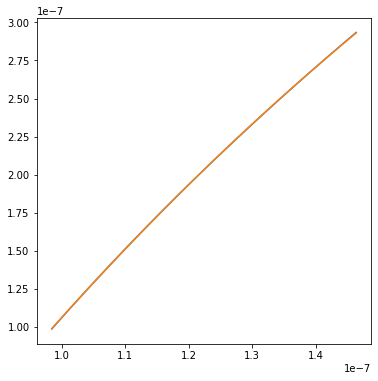

[-1.25763254e+07+2.78524356e-08j  7.13450217e+00-7.50768281e-15j
 -4.81777060e-07+4.50905137e-22j]


In [96]:
#looking at relation between varying height and radius for moments

momentarr = np.array(momentinc) #[j, :] is for changing height with rad j, [:, i] is for changing radius with height i 

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(momentarr[:, 0], momentarr[0, :])

slope = np.polyfit(momentarr[:, 0], momentarr[0, :], 2)
X_ = np.linspace(momentarr[:, 0].min(), momentarr[:, 0].max(), 500)
ax.plot(X_, slope[0]*X_**2 + slope[1]*X_+slope[2])
plt.show()
print(slope)

(2.8382967906053847e-15-15.450968080927593j)


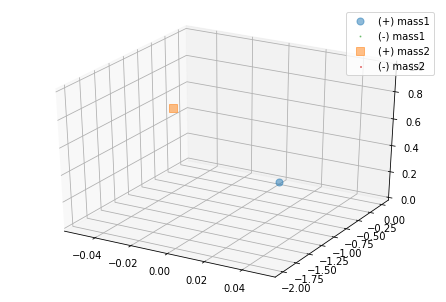

In [98]:
#looking at the multipole between two points -- should be simple to make conclusions from

#rectangle(mass, x, y, z, nx, ny, nz):
p1 = gshp.rectangle(10, 0, 0, 0, 1, 1, 1)
p2 = rotate_trans(p1, 0, [0, -2, 1])
fig, ax = glb.display_points(p1, p2)
ax.set_zlim([0, 1])
totalmass = np.concatenate([p1, p2])
print(p2m.qmoment(2, 1, totalmass))

(1.419211475460852e-09-7725827.432850911j)


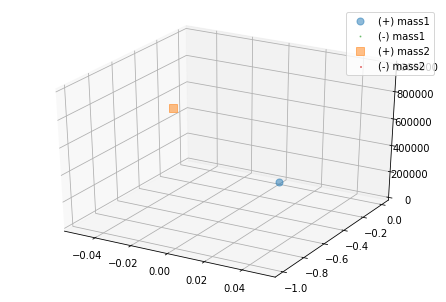

In [99]:
#increasing the height of the second point by a LOT

p1 = gshp.rectangle(10, 0, 0, 0, 1, 1, 1)
p2 = rotate_trans(p1, 0, [0, -1, 1000000])
fig, ax = glb.display_points(p1, p2)
ax.set_zlim([0, 1000000])
totalmass = np.concatenate([p1, p2])
print(p2m.qmoment(2, 1, totalmass))